# Accesso a Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Descarga del dataset

In [ ]:
# Instalar kaggle para tener acceso mediante API KEY
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descarga del dataset Chest X-Ray Images (Pneumonia)
# link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

100% 2.29G/2.29G [00:23<00:00, 95.3MB/s]
100% 2.29G/2.29G [00:23<00:00, 104MB/s] 


In [ ]:
# Eliminado de ficheros y carpetas innecesarias
!rm chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX/
!rm -rf chest_xray/chest_xray/
# La carpeta 'val' solo tiene 16 imágenes por lo que las pasamos al conjunto de 'train'
!cp -a chest_xray/val/NORMAL/. chest_xray/train/NORMAL/
!cp -a chest_xray/val/PNEUMONIA/. chest_xray/train/PNEUMONIA/
!rm -rf chest_xray/val/

# Importar las librerías

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.applications import ResNet50V2
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings

sns.set()
warnings.filterwarnings("ignore")

# Construir el modelo CNN

In [ ]:
target_size = (220, 220)
batch_size = 32
train_directory = "chest_xray/train"
test_directory = "chest_xray/test"

In [ ]:
resnet50 = ResNet50V2(weights="imagenet", input_shape=(*target_size, 3), include_top=False)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
def model_builder():
    classifier = Sequential()
    classifier.add(resnet50)
    for layer in resnet50.layers:
        layer.trainable = False
    classifier.add(Flatten())
    classifier.add(Dense(units=128, activation="relu"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(units=1, activation="sigmoid"))
    classifier.compile(optimizer="adam",
                       loss="binary_crossentropy",
                       metrics=["accuracy"])
    return classifier

In [ ]:
classifier = model_builder()
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36410113 (138.89 MB)
Trainable params: 12845313 (49.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


# Ajustar la CNN a las imágenes para entrenar

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

training_dataset = train_datagen.flow_from_directory(
    directory=train_directory,
    shuffle=True,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

validation_dataset = train_datagen.flow_from_directory(
    directory=train_directory,
    shuffle=True,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [ ]:
train_images, train_labels = next(training_dataset)
label_names = {
    0: "Normal",
    1: "Pneumonia"
}

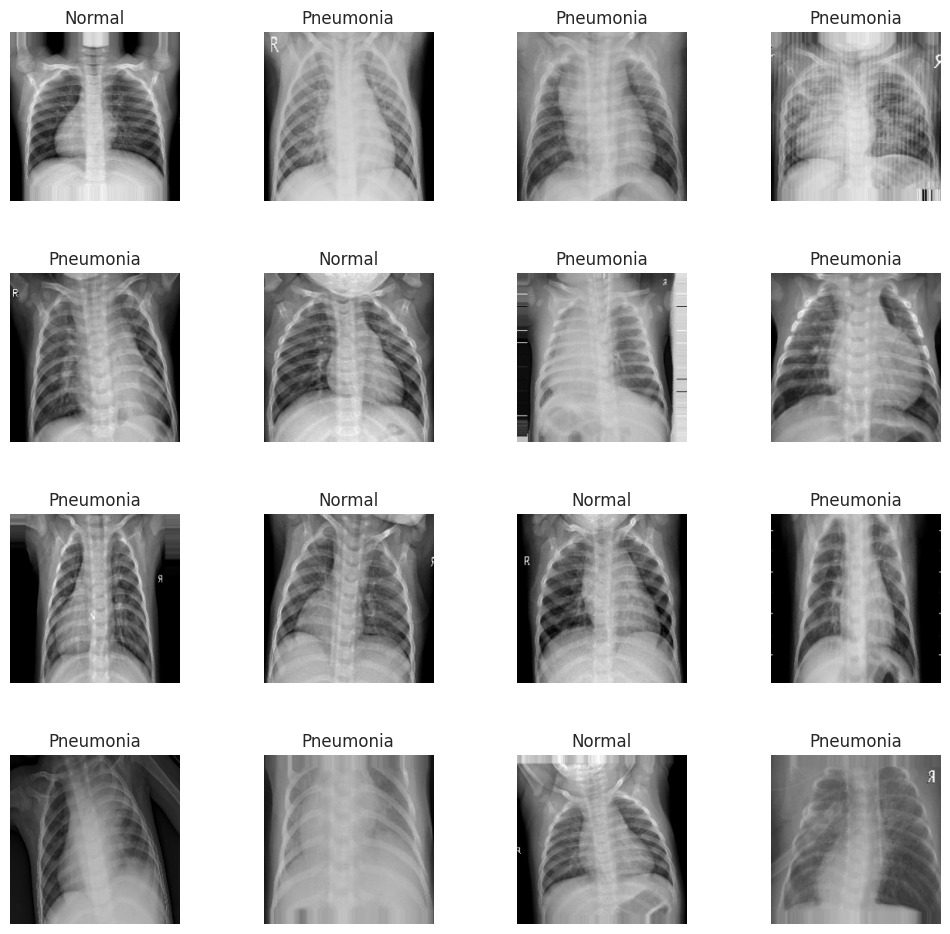

In [ ]:
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[train_labels[i]])
    axes[i].axis("off")

plt.subplots_adjust(wspace=0.5)

In [ ]:
modelpath = "/content/drive/MyDrive/chest-xray-classification/checkpoint/mymodel.hdf5"
checkpoint = ModelCheckpoint(filepath=modelpath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

In [ ]:
class_weight = compute_class_weight("balanced", classes=np.unique(training_dataset.classes), y=training_dataset.classes)
class_weight = dict(zip(np.unique(training_dataset.classes), class_weight))

In [ ]:
history = classifier.fit(
    training_dataset,
    steps_per_epoch=training_dataset.n//batch_size,
    epochs=50,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.n//batch_size,
    class_weight=class_weight,
    callbacks=[checkpoint]
)

Epoch 1/50
130/130 [==============================] - ETA: 0s - loss: 1.2446 - accuracy: 0.8818
Epoch 1: val_loss improved from inf to 0.18113, saving model to /content/drive/MyDrive/chest-xray-classification/checkpoint/mymodel.hdf5
130/130 [==============================] - 160s 1s/step - loss: 1.2446 - accuracy: 0.8818 - val_loss: 0.1811 - val_accuracy: 0.9365
Epoch 2/50
130/130 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9218
Epoch 2: val_loss improved from 0.18113 to 0.16961, saving model to /content/drive/MyDrive/chest-xray-classification/checkpoint/mymodel.hdf5
130/130 [==============================] - 139s 1s/step - loss: 0.2505 - accuracy: 0.9218 - val_loss: 0.1696 - val_accuracy: 0.9443
Epoch 3/50
130/130 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9199
Epoch 3: val_loss improved from 0.16961 to 0.12788, saving model to /content/drive/MyDrive/chest-xray-classification/checkpoint/mymodel.hdf5
130/130 [====================

# Visualizar evolución del loss y accuracy a lo largo de las epochs

In [ ]:
def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title("Model " + title)
    ax.set_ylabel(title)
    ax.set_xlabel("Epochs")
    ax.legend(["Training", "Validation"])

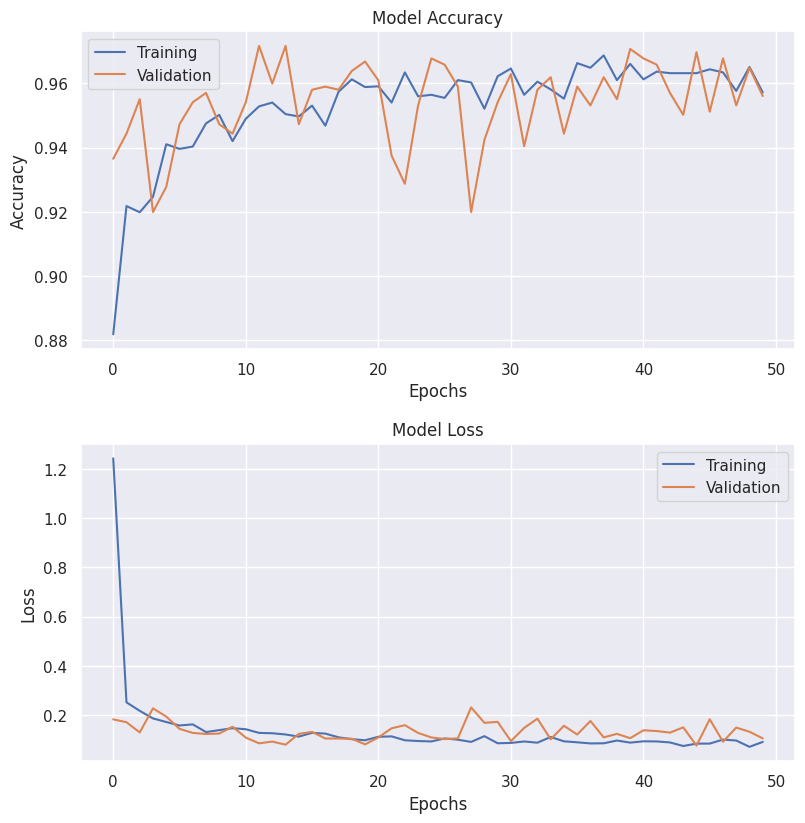

In [ ]:
plt.subplots(figsize=(8, 8))
plt.tight_layout()
display_training_curves(history.history["accuracy"], history.history["val_accuracy"], "Accuracy", 211)
display_training_curves(history.history["loss"], history.history["val_loss"], "Loss", 212)
plt.subplots_adjust(hspace=0.3)
plt.show()

# Predicciones sobre el conjunto de test

In [ ]:
model = load_model(filepath=modelpath)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
testing_dataset = test_datagen.flow_from_directory(
    directory=test_directory,
    shuffle=True,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary"
)

evaluate = model.evaluate(testing_dataset, steps=testing_dataset.n//batch_size, verbose=1)

print("Precisión en el conjunto de test: {}".format(evaluate[1]))

Found 624 images belonging to 2 classes.
19/19 [==============================] - 8s 362ms/step - loss: 0.3422 - accuracy: 0.9013
Precisión en el conjunto de test: 0.9013158082962036


In [ ]:
prediction = []
original = []
image = []
threshold = 0.5

for label in training_dataset.class_indices:
    folder_path = os.path.join(test_directory, label)
    for item in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, item))
        img = cv2.resize(img, target_size)
        image.append(img)
        img = img/255
        img = img.reshape(-1, *target_size, 3)
        predict = (model.predict(img, verbose=0)[0][0] > threshold).astype("int32")
        prediction.append(predict)
        original.append(training_dataset.class_indices[label])

100%|██████████| 390/390 [00:35<00:00, 10.89it/s]


In [ ]:
score = accuracy_score(original, prediction)
print("Eficacia de la predicción: {}".format(score.round(4)))

Eficacia de la predicción: 0.8958


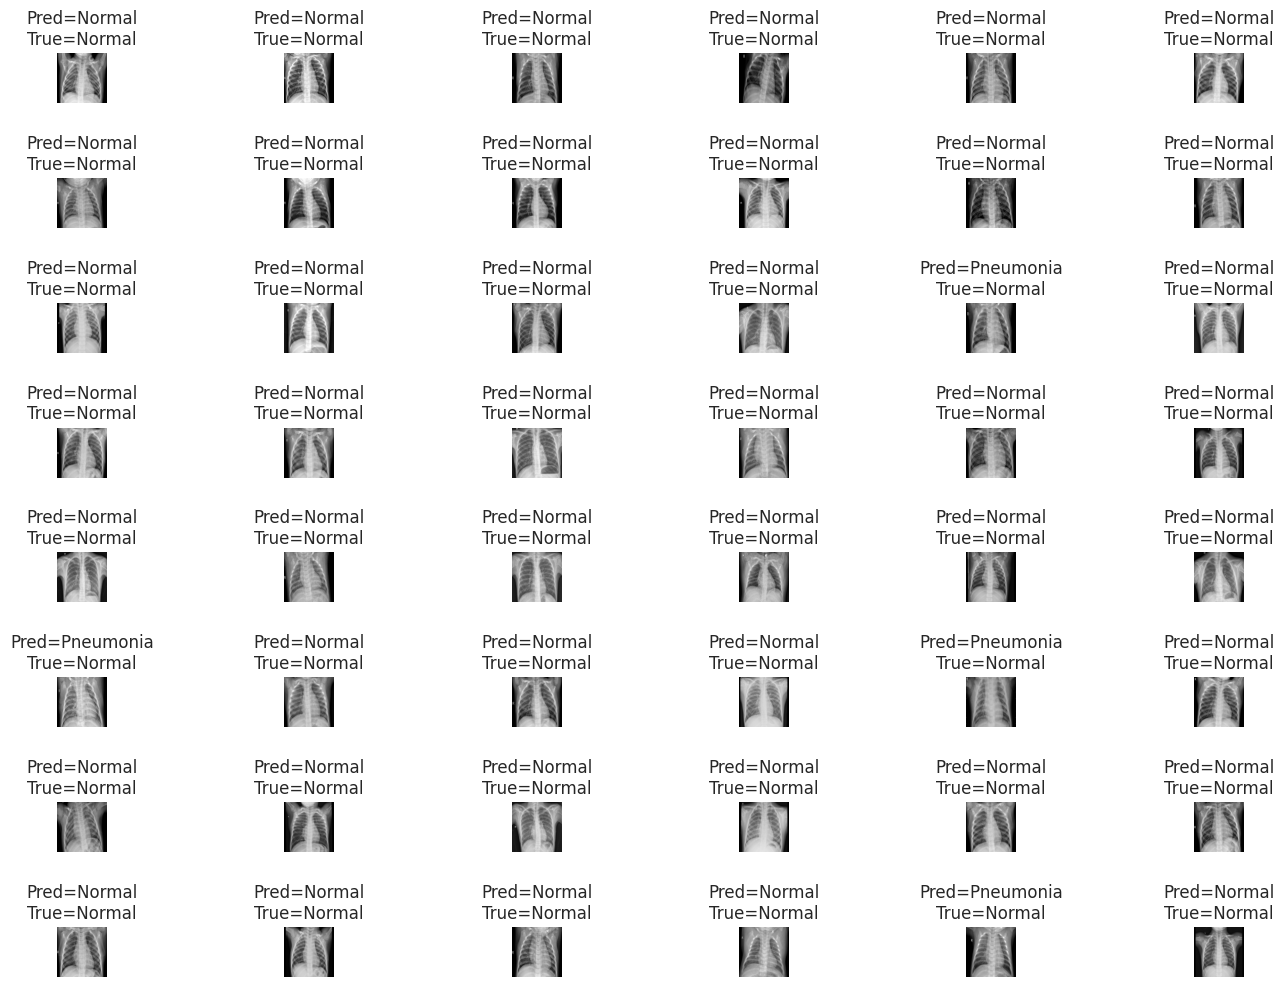

In [ ]:
L = 8
W = 6

fig, axes = plt.subplots(L, W, figsize=(16, 12))
axes = axes.ravel()

for i in np.arange(L*W):
    axes[i].imshow(image[i])
    pred_label = label_names[prediction[i]]
    true_label = label_names[original[i]]
    axes[i].set_title("Pred={}\nTrue={}".format(pred_label, true_label))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1.2, hspace=1.5)

# Matriz de Confusión

In [ ]:
print(classification_report(original, prediction, target_names=["Pneumonia", "Normal"]))

              precision    recall  f1-score   support

   Pneumonia       0.93      0.78      0.85       234
      Normal       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.87      0.88       624
weighted avg       0.90      0.90      0.89       624



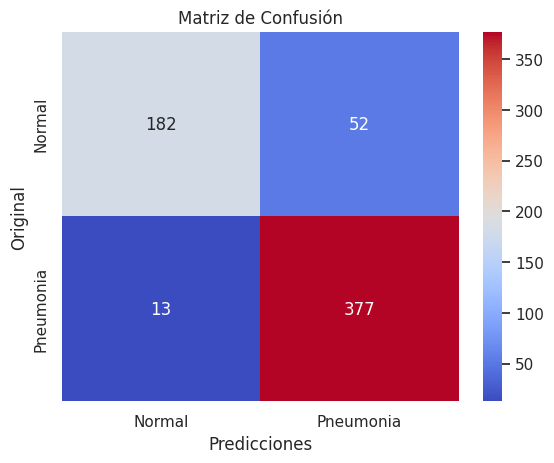

In [ ]:
cm = confusion_matrix(original, prediction)
ax = plt.subplot()

sns.heatmap(cm, annot=True, ax=ax, fmt=".0f", cmap="coolwarm")
ax.set_xticklabels(list(label_names.values()))
ax.set_yticklabels(list(label_names.values()))
ax.set_xlabel("Predicciones")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusión")
plt.show()

# Curva ROC

In [ ]:
fpr, tpr, _ = roc_curve(original, prediction)
auc_score = roc_auc_score(original, prediction).round(4)

print("AUC: ", auc_score)

AUC:  0.8722


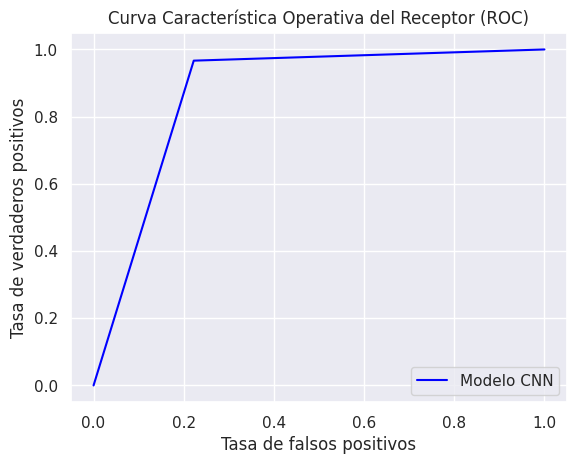

In [ ]:
plt.plot(fpr, tpr, linestyle="-", color="blue", label="Modelo CNN")

plt.title("Curva Característica Operativa del Receptor (ROC)")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend(loc="best")
plt.show()